# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from matplotlib.colors import colorConverter, ListedColormap
from matplotlib import cm #
import os
import tqdm
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from keras.datasets import mnist
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from keras.optimizers import SGD
%matplotlib inline
np.random.seed(seed=1)

Using Theano backend.
/home/kacper/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Small MNIST 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
sm_train = mnist_x_train[0:500].astype('float32') / 255.
sm_y_train = mnist_y_train[0:500]
sm_test = mnist_x_test[0:500].astype('float32') / 255.
sm_y_test = mnist_y_test[0:500]
sm_train = sm_train.reshape((len(sm_train), np.prod(sm_train.shape[1:])))
sm_test = sm_test.reshape((len(sm_test), np.prod(sm_test.shape[1:])))


In [3]:
def logistic(z): 
    return 1 / (1 + np.exp(-z))

def nn(x, w): 
    return logistic(x.dot(w.T))

def nn_predict(x,w): 
    return np.array(np.around(nn(x,w)))

def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

In [4]:
# Define and generate the samples
nb_of_samples_per_class = 100  # The number of sample in each class
red_mean = [-1,0]  # The mean of the red class
blue_mean = [1,0]  # The mean of the blue class
std_dev = 1.2  # standard deviation of both classes
# Generate samples from both classes
x_red = np.random.randn(nb_of_samples_per_class, 2) * std_dev + red_mean
x_blue = np.random.randn(nb_of_samples_per_class, 2) * std_dev + blue_mean

# Merge samples in set of input variables x, and corresponding set of output variables t
X_toy = np.vstack((x_red, x_blue))
t_toy = np.vstack((np.zeros((nb_of_samples_per_class,1)), np.ones((nb_of_samples_per_class,1))))

toy_train, toy_test, toy_y_train, toy_y_test = train_test_split(X_toy, t_toy, test_size=0.15)

# Przyda sie do sekcji o kerasie
toy_y_train_one_hot = keras.utils.to_categorical(toy_y_train)
toy_y_test_one_hot = keras.utils.to_categorical(toy_y_test)

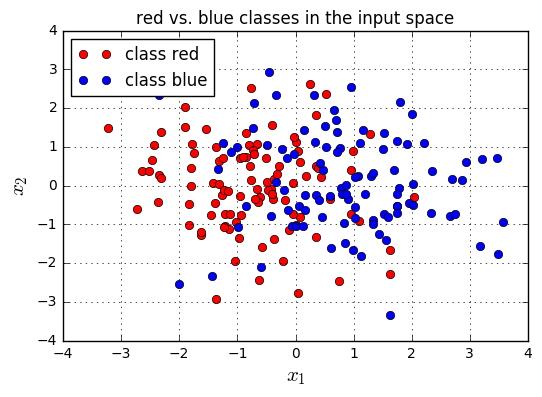

In [5]:
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-4, 4, -4, 4])
plt.title('red vs. blue classes in the input space')
plt.show()

### Funkcja kosztu nie jest już taka prosta!

In [6]:
# Plot the cost in function of the weights
# Define a vector of weights for which we want to plot the cost
nb_of_ws = 100 # compute the cost nb_of_ws times in each dimension
ws1 = np.linspace(-5, 5, num=nb_of_ws) # weight 1
ws2 = np.linspace(-5, 5, num=nb_of_ws) # weight 2
ws_x, ws_y = np.meshgrid(ws1, ws2) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize cost matrix

# Fill the cost matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        cost_ws[i,j] = cost(nn(toy_train, np.asmatrix([ws_x[i,j], ws_y[i,j]])) , toy_y_train)

### Zadanie 1, Nauka regresji logistycznej przez GD [2pkt]

(Uwaga: jest GD nie SGD ponieważ liczymy gradient na całym zbiorze)

1. Zaimplementuj GD dla zbioru danych toy. 
2. Wygeneruj wizualizacje procesu uczenia (ostatnia komórka)
3. Narysuj wizualizacje dla learning_rate=10.0, 5.0, 2.5, 1.0
4. Dla jakiego learning_rate osiągamy najlepszą dokladnosc na (toy_test, toy_y_test)?

Co powinno wyjść dla odpowiednio 5.0 oraz 2.5

<img width=200 src="figures/L9/lr5.png">
<img width=200 src="figures/L9/lr2.5.png">

Uwaga: Należy uśredniać gradient w funkcji "gradient", dziękujemy za zauważenie błędu Krzysztofowi Paskowi.

lr = 1
Znalezione w: [[-1.17013433 -1.50159367]]
Dokładność przy znalezionym w: 0.47333333333333333
lr = 2.5
Znalezione w: [[ 0.76703925 -0.0802183 ]]
Dokładność przy znalezionym w: 0.5
lr = 5
Znalezione w: [[ 0.69209522 -0.04303331]]
Dokładność przy znalezionym w: 0.5
lr = 10
Znalezione w: [[ 3.05135046  0.67503657]]
Dokładność przy znalezionym w: 0.5133333333333333


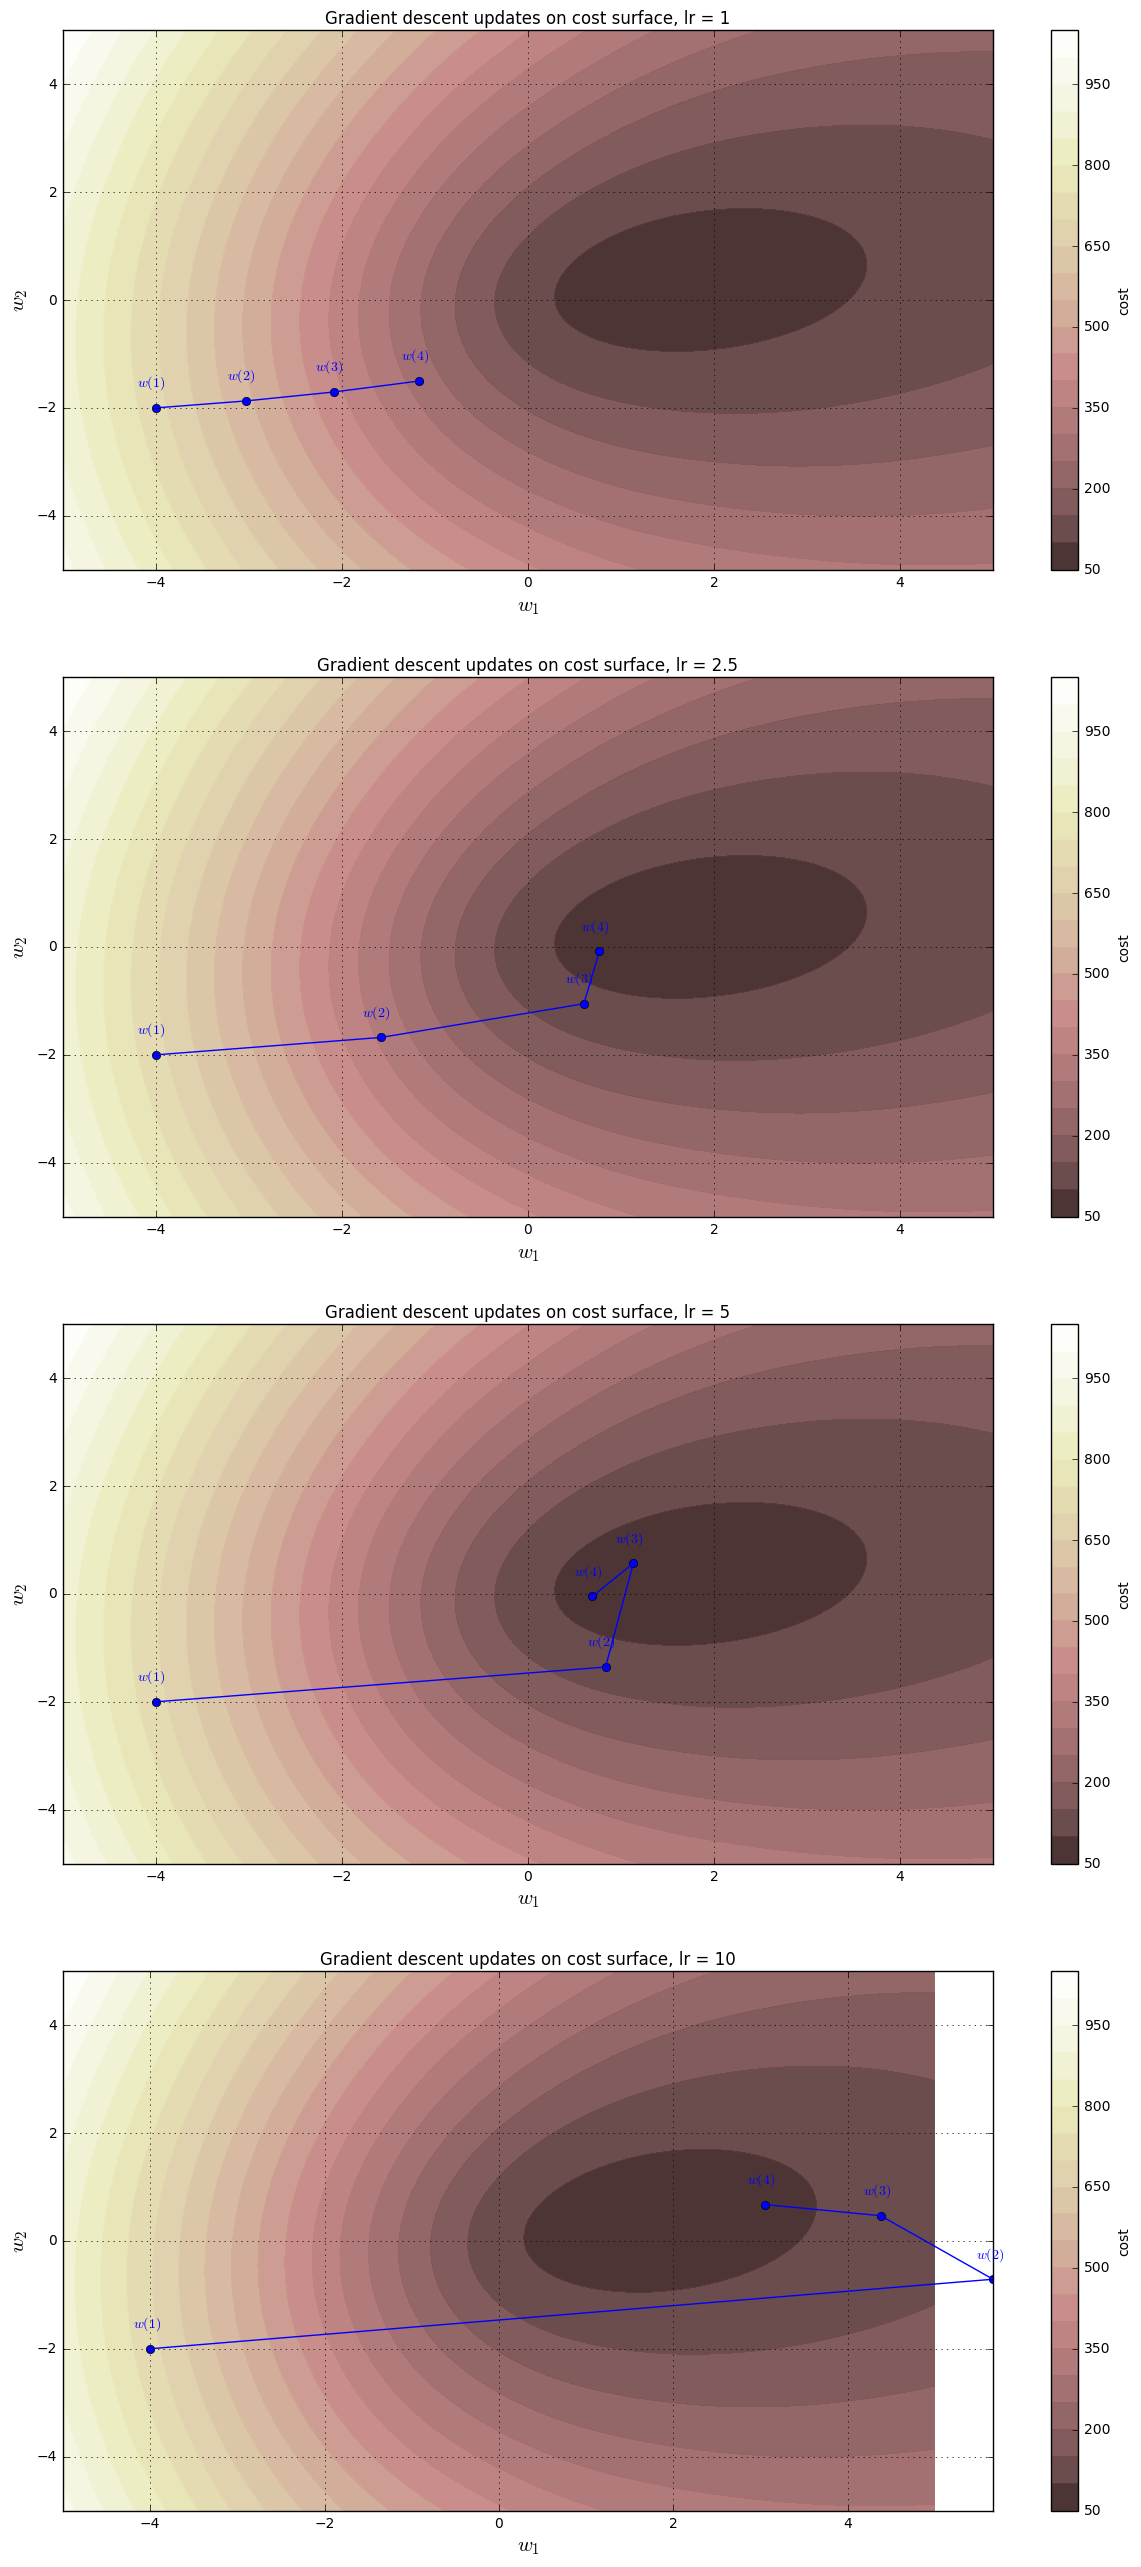

In [7]:
def gradient(w, x, t): 
    
    return np.mat(nn_predict(x,w)-t).T * np.mat(x)/len(t)
    
    
def delta_w(w_k, x, t, learning_rate):
    return gradient(w, x, t) * learning_rate


# Parametry uczenia
learning_rates = [1, 2.5, 5, 10]

plt.figure(figsize=(15,32))
for j in range(4):
    plt.subplot(4,1,j+1)
    w = np.asmatrix([-4, -2])
    learning_rate = learning_rates[j]

    # Uczenie
    nb_of_iterations = 10 
    w_iter = [w] 
    for i in range(nb_of_iterations):
        dw = delta_w(w, toy_train, toy_y_train, learning_rate) 
        w = w - dw 
        w_iter.append(w)


    # Plot the first weight updates on the error surface
    # Plot the error surface
    plt.contourf(ws_x, ws_y, cost_ws, 20, alpha=0.9, cmap=cm.pink)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('cost')



    
    # Plot the updates
    for i in range(1, 4): 
        w1 = w_iter[i-1]
        w2 = w_iter[i]
        # Plot the weight-cost value and the line that represents the update
        plt.plot(w1[0,0], w1[0,1], 'bo')  # Plot the weight cost value
        plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], 'b-')
        plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(i), color='b')
    w1 = w_iter[3]  
    # Plot the last weight
    plt.plot(w1[0,0], w1[0,1], 'bo')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(4), color='b') 
    # Show figure
    plt.xlabel('$w_1$', fontsize=15)
    plt.ylabel('$w_2$', fontsize=15)
    plt.title('Gradient descent updates on cost surface, lr = {0}'.format(learning_rate))
    plt.grid()
    
    print ("lr = {0}".format(learning_rate))
    print("Znalezione w: {0}".format(w_iter[3]))
    print("Dokładność przy znalezionym w: {0}".format(np.mean(nn_predict(w_iter[3], toy_test) == toy_y_test)))

plt.show()

    
    

## Zadanie 2, Proste modyfikacje [2pkt]


1. (1pkt) Zmodyfikuj powyższą sieć tak aby osiągnęła min. 95% na zmniejszonym do 30 przykładów zbiorze trenującym w rozważanym datasecie. Odpowiedz na pytania:
   * Czy ten model osiąga lepszy wynik na zbiorze testowym niż regresja logistyczna?
   * Czy można osiągnąć lepszy wynik na tym zbiorze danych, nawet jeśli posiadalibyśmy nieskończoną próbkę danych?
2. (1pkt) Naucz 2 warstwową sieć na smallMNIST. Czy dla jakiegoś rozmiaru ukrytej warstwy osiąga lepszy wynik niż regresja logistyczna

In [8]:
# 2.1 
# 1. Definicja modelu
model = Sequential()

model.add(Dense(32, input_shape=(2,)))
model.add(Activation('tanh'))
for i in range(16):
    model.add(Dense(64))
    model.add(Activation('tanh'))

model.add(Dense(2))
model.add(Activation('softmax'))


# 2. Kompilacja
model.compile(optimizer=SGD(),  loss='categorical_crossentropy')

# 3. Uczenie
history = model.fit(toy_train[:30], toy_y_train_one_hot[:30], epochs=10000, batch_size = 30, verbose = 0)



# 4. Predykcja
toy_y_pred = model.predict(toy_test).argmax(axis=1)
toy_y_train_pred = model.predict(toy_train[:30]).argmax(axis=1)
print (np.mean(toy_y_train[:30].reshape(-1,) == toy_y_train_pred))
print (np.mean(toy_y_test.reshape(-1,) == toy_y_pred))

1.0
0.666666666667


In [9]:
# 2.1 pierwsza kropka
model = LogisticRegression()
model.fit(toy_train[:30],toy_y_train[:30])
pred = model.predict(toy_test)
print(np.mean(toy_y_test.reshape(-1,) == pred))
print("Wynik uzyskany przez regresję logistyczną jest wyższy.")

0.7
Wynik uzyskany przez regresję logistyczną jest wyższy.


/home/kacper/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#2.1 druga kropka

W rzeczywistości jedyna przesłanka na podstawie której możemy podejmować decyzję przy takich danych, to wartość współrzędnej $x_{1}$ punktu. Jeśli jest ona dodatnia, większe jest prawdopodobieństwo, że punkt jest niebieski, jeśli ujemna, to prawdopodobniej jest czerwony.

Należy więc zadać sobie pytanie, jakie jest prawdopodobieństwo, że czerwony punkt będzie miał współrzędną $x_{1}$ ujemną. Dzięki symetrii rozkładów klas czerwonej i niebieskiej jest to zarazem prawdopodobieństwo poprawnej klasyfikacji punktu do grupy przy idealnym klasyfikatorze.

Współrzędna $x_{1}$ dla punktu czerwonego ma rozkład $X \sim N(-1,1.2^{2})$. Korzystając z zależności:

$$ P(X \le x) = \Phi\left(\frac{x-\mu}{\sigma}\right),$$

gdzie $\Phi$ to dystrybuanta standardowego rozkładu normalnego $N(0,1)$, możemy odczytać z tablic, że:

$$ P(X \le 0) = \Phi\left(\frac{-\mu}{\sigma}\right)=\Phi\left(\frac{5}{6}\right) \approx 0.797 .$$

Widzimy więc, więc niezależnie od objętości danych trenujących, każdy wynik z dokładnością wyższą niż $0.797$, jest kwestią szczęścia, a nie faktycznej nauki modelu.

In [15]:
##2.2
#Sieć neuronowa:


sm_y_train_one_hot = keras.utils.to_categorical(sm_y_train)
sm_y_test_one_hot = keras.utils.to_categorical(sm_y_test)


model = Sequential()

model.add(Dense(784, input_shape=(784,)))
model.add(Activation('tanh'))
model.add(Dense(10))
model.add(Activation('softmax'))


# 2. Kompilacja
model.compile(optimizer=SGD(),  loss='categorical_crossentropy')

# 3. Uczenie
history = model.fit(sm_train, sm_y_train_one_hot, epochs=1000, verbose = 0)



# 4. Predykcja
sm_y_pred = model.predict(sm_test).argmax(axis=1)
sm_y_train_pred = model.predict(sm_train).argmax(axis=1)
print (np.mean(sm_y_train.reshape(-1,) == sm_y_train_pred))
print (np.mean(sm_y_test.reshape(-1,) == sm_y_pred))

1.0
0.848


In [11]:
# Logistic Regression
model = LogisticRegression()
model.fit(sm_train, sm_y_train)
pred = model.predict(sm_test)
print(np.mean(sm_y_test.reshape(-1,) == pred))
print("Wynik uzyskany przez regresję logistyczną jest niższy.")

0.846
Wynik uzyskany przez regresję logistyczną jest niższy.


## Zadanie 3, czy cechy pomagają w kNN [1pkt]

1. Naucz PCA jedynie na cyfrach 5 i załącz analogiczny plot jak powyżej

2. Użyj nauczonych cech (na całym zbiorze mnist) przez PCA do klasyfikacji kNN na zbiorze small MNIST. Jaki można osiągnąć wynik? Użyj KNeighborsClassifier z pakietu sklearn. Dopasuj parametry PCA oraz tak KNeighborsClassifier aby osiągnąć najlepszy wynik na zbiorze sm_test, wymagany jest wynik powyżej 80% na zbiorze testowym.

/home/kacper/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


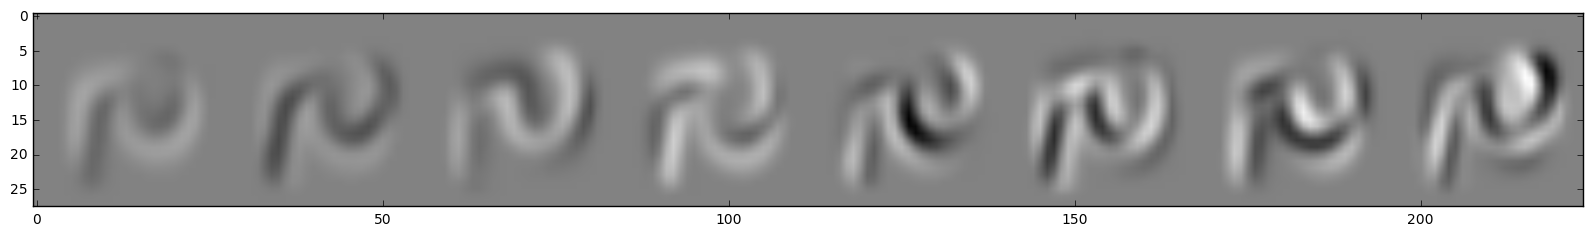

In [12]:
#3.1
mnist_x_train_fives = np.array([mnist_x_train[i]  for i in range(len(mnist_y_train)) if  mnist_y_train[i] == 5])

pca = RandomizedPCA(n_components=8, iterated_power=15, whiten=True)
pca.fit_transform(mnist_x_train_fives.reshape(mnist_x_train_fives.shape[0], -1))

plt.figure(figsize=(20, 8 * 20))
plt.imshow(pca.components_.reshape((8 * 28, 28)).T, cmap="gray")

In [13]:
whole_mnist_x = np.vstack([mnist_x_train.reshape(mnist_x_train.shape[0], -1), mnist_x_test.reshape(mnist_x_test.shape[0], -1)])

In [14]:
from sklearn.neighbors import KNeighborsClassifier

pca = PCA(n_components=22, whiten=True)

pca.fit(whole_mnist_x)
X_train_transformed = pca.transform(sm_train)
X_test_transformed = pca.transform(sm_test)
   
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_transformed, sm_y_train) 

print ("test accuracy:", accuracy_score(sm_y_test, knn.predict(X_test_transformed)))


test accuracy: 0.834
